In [1]:
import os, sys, re, datetime, shutil
import numpy as np
import astropy.units as u
from astropy.table import Table

In [2]:
CO = {}
CO['Einstein_A'] = np.array([
    7.203e-08, 6.910e-07, 2.497e-06, 6.126e-06, 1.221e-05, 2.137e-05, 3.422e-05, 5.134e-05, 7.330e-05, 1.006e-04, 
    1.339e-04, 1.735e-04, 2.200e-04, 2.739e-04, 3.354e-04, 4.050e-04, 4.829e-04, 5.695e-04, 6.650e-04, 7.695e-04, 
    8.833e-04, 1.006e-03, 1.139e-03, 1.281e-03, 1.432e-03, 1.592e-03, 1.761e-03, 1.940e-03, 2.126e-03, 2.321e-03, 
    2.524e-03, 2.735e-03, 2.952e-03, 3.175e-03, 3.404e-03, 3.638e-03, 3.878e-03, 4.120e-03, 4.365e-03, 4.613e-03, 
])
CO['E_u'] = np.array([
    5.53,     16.60,    33.19,   55.32,   82.97,  116.16,  154.87,  199.11,  248.88, 304.16, 
    364.97,   431.29,  503.13,  580.49,  663.35,  751.72,  845.59,  944.97, 1049.84, 1160.20, 
    1276.05, 1397.38, 1524.19, 1656.47, 1794.23, 1937.44, 2086.12, 2240.24, 2399.82, 2564.83, 
    2735.28, 2911.15, 3092.45, 3279.15, 3471.27, 3668.78, 3871.69, 4079.98, 4293.64, 4512.67, 
])

In [3]:
def calc_Q(E_u, T_kin, N=None):
    E_j = np.concatenate([[0.0], E_u])
    if N is None:
        N = len(E_j)
    j = np.arange(N)
    E_j = E_j[0:N]
    #E_j = (j*(j+1)) * E_u[0]
    return np.sum(1.0 * (j+(j+1)) * np.exp(-1.0 * E_j / T_kin))

In [4]:
list_T_kin = np.logspace(np.log10(5), np.log10(2000), num=200, endpoint=True)
list_Q = np.array([calc_Q(CO['E_u'], T_kin) for T_kin in list_T_kin])
list_Q_N1 = np.array([calc_Q(CO['E_u'], T_kin, N=1) for T_kin in list_T_kin])
list_Q_N2 = np.array([calc_Q(CO['E_u'], T_kin, N=2) for T_kin in list_T_kin])
list_Q_N3 = np.array([calc_Q(CO['E_u'], T_kin, N=3) for T_kin in list_T_kin])

Lequeux2005 Eq.4.50 approx Q: abs diff 0.3508868923351005 ... 0.32958989809900174
Lequeux2005 Eq.4.50 approx Q: rel diff 0.08609484039373795 ... 0.009166583774456944
Lequeux2005 Eq.4.50 approx Q: max abs diff 0.3508868923351005
Lequeux2005 Eq.4.50 approx Q: max rel diff 0.08609484039373795
popt [ 3.29012822 -0.84228216]
DZLIU Schechter Func approx Q: rel diff [(5.000000000000001, 0.5418239785115212), (5.152828434410521, 0.526078847001263), (5.310328174893917, 0.5103573085526618), (5.4726420031289384, 0.49467931320870967), (5.63991706501443, 0.479064220502302), (5.812305004064696, 0.46353075312786535), (5.989962098882225, 0.44809695642927827), (6.17304940483233, 0.43278016357257376), (6.361732900048194, 0.41759696623002157), (6.556183635898648, 0.4025631905680027), (6.756577892055102, 0.3876938783038196), (6.963097336298206, 0.37300327257548427), (7.175929189209109, 0.3585048083527974), (7.395266393894627, 0.3442111071069776), (7.621307790900158, 0.33013397544907597), (7.854258298468951

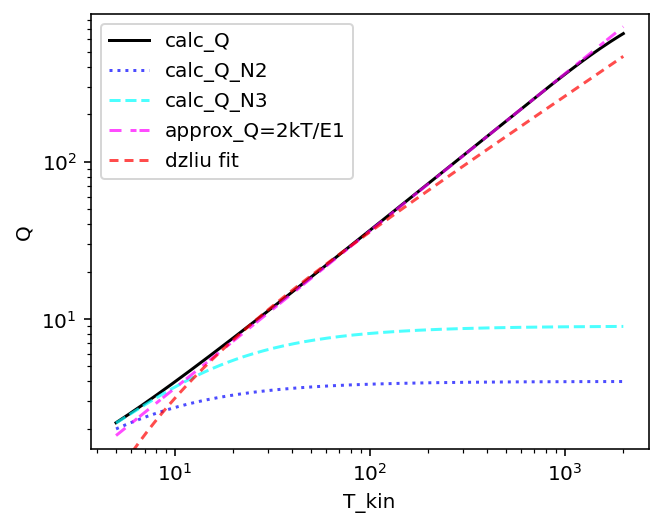

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('T_kin')
ax.set_ylabel('Q')
x = list_T_kin
#x = 1./list_T_kin
ax.plot(list_T_kin, list_Q, color='k', label='calc_Q')
ax.plot(list_T_kin, list_Q_N2, ls='dotted', color='blue', alpha=0.7, label='calc_Q_N2')
ax.plot(list_T_kin, list_Q_N3, ls='dashed', color='cyan', alpha=0.7, label='calc_Q_N3')
#ax.plot(list_T_kin, 10**(np.log10(list_T_kin / 5.53) * 1.3), dashes=(3,2), color='#222222', alpha=0.7)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim())


# Lequeux2005 Eq.4.50, Q \approx 2 k T / E_1
approx_Q = (list_T_kin) * 2.0 / 5.53
ax.plot(list_T_kin, approx_Q, dashes=(4,3,2,1), color='magenta', alpha=0.7, label='approx_Q=2kT/E1') # Q \approx 2 k T / E_1
absdiff = np.abs((approx_Q - list_Q))
reldiff = np.abs((approx_Q - list_Q)/list_Q)
absdiff = absdiff[np.logical_and(list_T_kin>=10., list_T_kin<=100.)]
reldiff = reldiff[np.logical_and(list_T_kin>=10., list_T_kin<=100.)]
print('Lequeux2005 Eq.4.50 approx Q: abs diff', absdiff[0], '...', absdiff[-1])
print('Lequeux2005 Eq.4.50 approx Q: rel diff', reldiff[0], '...', reldiff[-1])
maxabsdiff = np.max(absdiff)
maxreldiff = np.max(reldiff)
print('Lequeux2005 Eq.4.50 approx Q: max abs diff', maxabsdiff)
print('Lequeux2005 Eq.4.50 approx Q: max rel diff', maxreldiff)

#x = (5.53/list_T_kin)
#ax.plot(list_T_kin, (1.1 * (x)**(-1.1) * np.exp(-x)), dashes=(3,2), color='red', alpha=0.7)

#x = (1.0/list_T_kin)
x = (5.53/list_T_kin)
from scipy.optimize import curve_fit
#def func(x, a, b, c):
#    return (a * (x/c)**(b) * np.exp(-x/c))
def func(x, a, b):
    return (a * (x)**(b) * np.exp(-x))
x_for_fitting = x[np.logical_and(list_T_kin>=10., list_T_kin<=100.)] # fit only 10 < Tkin < 100 K
y_for_fitting = list_Q[np.logical_and(list_T_kin>=10., list_T_kin<=100.)] # fit only 10 < Tkin < 100 K
popt, pcov = curve_fit(func, x_for_fitting, y_for_fitting)
print('popt', popt)
pfit = func(x, *popt)
absdiff = np.abs((pfit - list_Q))
reldiff = np.abs((pfit - list_Q)/list_Q)
print('DZLIU Schechter Func approx Q: rel diff', list(zip(list_T_kin, reldiff, )))
absdiff = absdiff[np.logical_and(list_T_kin>=10., list_T_kin<=100.)]
reldiff = reldiff[np.logical_and(list_T_kin>=10., list_T_kin<=100.)]
print('DZLIU Schechter Func approx Q: abs diff', absdiff[0], '...', absdiff[-1])
print('DZLIU Schechter Func approx Q: rel diff', reldiff[0], '...', reldiff[-1])
maxabsdiff = np.max(absdiff)
maxreldiff = np.max(reldiff)
print('DZLIU Schechter Func approx Q: max abs diff', maxabsdiff)
print('DZLIU Schechter Func approx Q: max rel diff', maxreldiff)
ax.plot(list_T_kin, pfit, dashes=(3,2), color='red', alpha=0.7, label='dzliu fit')
#print('func', r'Q \approx %.3f \left(\frac{%.3f}{T_{\mathrm{kin}}}\right)^{%.3f} \times \mathrm{e}^{-%.3f/T_{\mathrm{kin}}}'%(
#      popt[0], 1./popt[2], popt[1], 1./popt[2]))
print('func', r'Q \approx %.3f \left(\frac{%.3f}{T_{\mathrm{kin}}}\right)^{%.3f} \times \mathrm{e}^{-%.3f/T_{\mathrm{kin}}}'%(
      popt[0], 5.53, popt[1], 5.53))
ax.legend()